In [ ]:
!pip install lime
!pip install transformers

     |████████████████████████████████| 276kB 4.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=0714c283827ec2d20f5aa9e8b79ed38181f3755c1c70e3d9bfb114643e9b00af
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 1.3MB 4.3MB/s 
     |████████████████████████████████| 1.1MB 12.7MB/s 
     |████████████████████████████████| 890kB 35.0MB/s 
     |████████████████████████████████| 2.9MB 42.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e41963660542595182a004337a5e8d0a34cee03a19d58abff664744e77ec66e8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
## for data
import json
import pandas as pd
import numpy as np
## for time checking
import time
import datetime
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [ ]:
# Connecting Google Drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cat = ['astrophysics', 'biology', 'business', 'computer science', 'linguistics', 'mathematics',  'physics', 'philosophy']

data = pd.read_csv("/content/drive/My Drive/topdown/train_data.csv")
dtf_test = pd.read_csv("/content/drive/My Drive/topdown/test_data.csv")
    
data = data[data['category']!='Others']
dtf_test = dtf_test[dtf_test['category']!='Others']
print(len(data[data['category'] == 'linguistics']))

3952


In [ ]:
print(set(data['category']))
print(set(dtf_test['category']))
print(len(data))

{'physics', 'mathematics', 'biology', 'business', 'philosophy', 'linguistics', 'astrophysics', 'computer science'}
{'physics', 'mathematics', 'biology', 'business', 'philosophy', 'linguistics', 'astrophysics', 'computer science'}
100097


In [ ]:
from nltk.tokenize import sent_tokenize
from numpy import nan

h =  data[data['category'] == 'linguistics']
d = data[data['category'] == 'computer science']
a = data[data['category'] == 'physics'] 
b = data[data['category'] == 'business']
c = data[data['category'] == 'biology']
e = data[data['category'] == 'astrophysics']
f = data[data['category'] == 'mathematics']
g = data[data['category'] == 'philosophy']

dtf = pd.concat([a, b,c,d,e,f,g, h], ignore_index=True)

dtf = dtf.rename(columns={"category":"y", "abstract":"text"})
dtf_test = dtf_test.rename(columns={"category":"y", "abstract":"text"})

In [ ]:
print(len(data[data['category'] == 'computer science']))
print(len(data[data['category'] == 'biology']))
print(len(data[data['category'] == 'physics']))
print(len(data[data['category'] == 'mathematics']))
print(set(dtf_test['y']))
print(len(dtf))
print(len(dtf_test))

15381
11244
20215
22176
{'mathematics', 'linguistics', 'astrophysics', 'biology', 'business', 'philosophy', 'physics', 'computer science'}
100097
25029


In [ ]:
## get target
import sklearn
dtf_train = dtf
dtf_train =  sklearn.utils.shuffle(dtf_train, random_state = 1)
dft_test = sklearn.utils.shuffle(dtf_test, random_state = 1)

y_train = dtf_train["y"].values
y_test = dtf_test["y"].values


In [ ]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [ ]:
# Creating a 'BERT-friendly' input for TEST data (중복되는 일부 변수는 제거)
corpus = dtf_test["text"]
maxlen = 512

## add special tokens
corpus_tokenized = [" ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
            str(txt).lower().strip()))[:maxqnans])+
            " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-2-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    

X_test = [np.asarray(idx, dtype='int32'), 
        np.asarray(masks, dtype='int32')]
        # np.asarray(segments, dtype='int32')]

In [ ]:
import tensorflow as tf

## inputs
idx = layers.Input((maxlen), dtype="int32", name="input_idx")
masks = layers.Input((maxlen), dtype="int32", name="input_masks")

## pre-trained bert with config
config = transformers.DistilBertConfig()
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp.distilbert(idx, attention_mask=masks)[0]

## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x1 = layers.Dense(64, kernel_initializer=tf.keras.initializers.he_uniform(), activation='relu')(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x1)

## compile
sgd = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam',
)

Adamax = tf.keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)


model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=sgd , metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay ((None, 512, 768),)  66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           distilbert[0][0]      

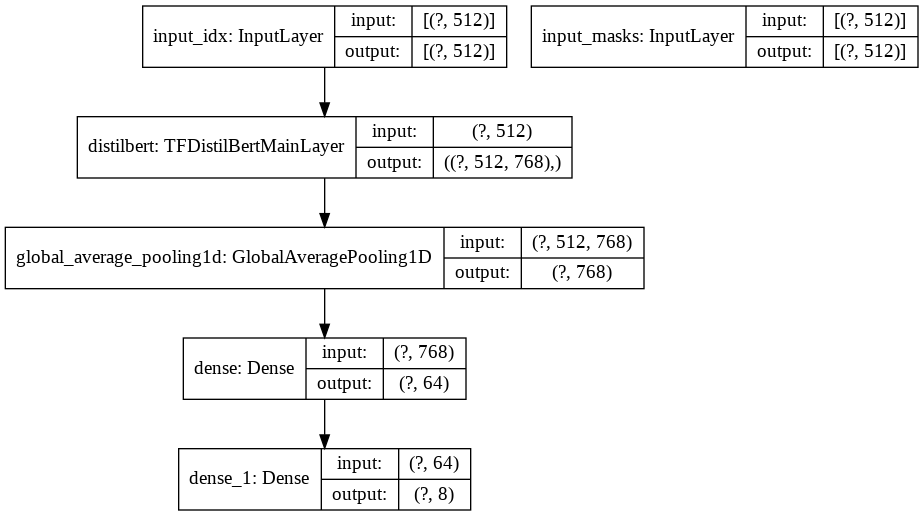

In [ ]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
%matplotlib inline

SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))
plot_model(model, to_file='name.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
## encode y
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
# dic_y_mapping = {0: 'ENTERTAINMENT', 1: 'POLITICS', 2:'TECH'}
# dic_y_mapping = {"ENTERTAINMENT": 0, "POLITICS": 1, "TECH": 2}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [ ]:

# ## train
# training = model.fit(x=X_train, y=y_train, batch_size=32, 
#                      epochs=3, shuffle=True, verbose=1, 
#                      validation_split=0.3)


Epoch 1/3
2190/2190 [==============================] - 1117s 510ms/step - loss: 0.2465 - accuracy: 0.9222 - val_loss: 0.1642 - val_accuracy: 0.9447
Epoch 2/3
2190/2190 [==============================] - 1114s 509ms/step - loss: 0.1643 - accuracy: 0.9439 - val_loss: 0.1546 - val_accuracy: 0.9470
Epoch 3/3
2190/2190 [==============================] - 1113s 508ms/step - loss: 0.1485 - accuracy: 0.9488 - val_loss: 0.1433 - val_accuracy: 0.9530


In [ ]:
model = models.load_model("/content/drive/My Drive/topdown/tdmodel")

## test
predicted_prob = model.predict(X_test)

['astrophysics' 'astrophysics' 'astrophysics' ... 'philosophy'
 'philosophy' 'philosophy'] ['astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'physics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', 'astrophysics', '

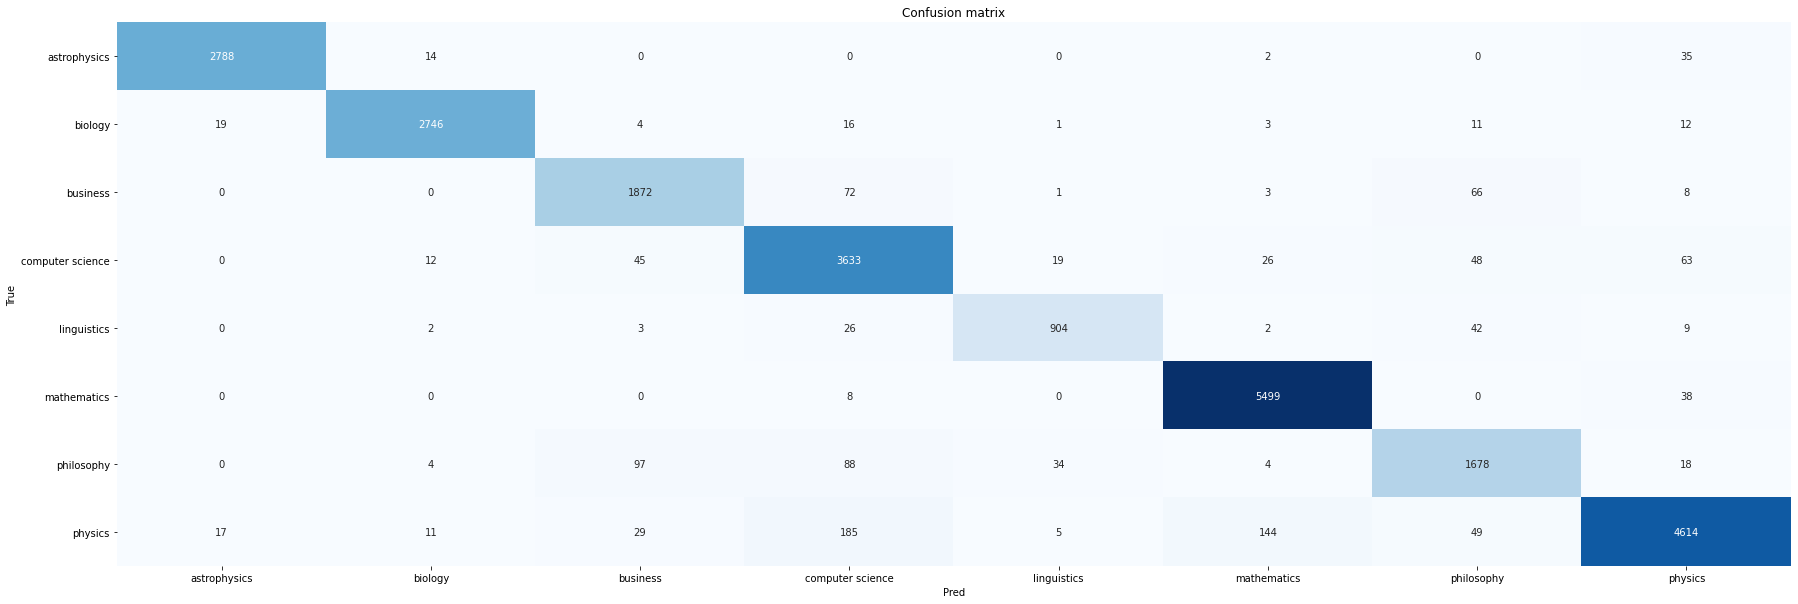

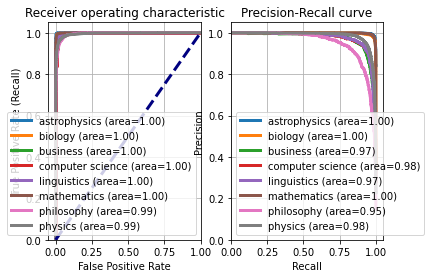

In [ ]:
from sklearn import metrics
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)

print(y_test, predicted)
print("Accuracy:",  round(accuracy,4))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)

# Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()


In [ ]:
  path = '/content/drive/My Drive/topdown/tdmodel'
  models.save_model(model, filepath=path, overwrite=True, include_optimizer=True, save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/topdown/tdmodel/assets


In [ ]:
dtf_test.iloc[2]['text']
"""
Epoch 1/3
926/926 [==============================] - 302s 326ms/step - loss: 0.2135 - accuracy: 0.9288 - val_loss: 0.1500 - val_accuracy: 0.9443
Epoch 2/3
926/926 [==============================] - 311s 335ms/step - loss: 0.1396 - accuracy: 0.9492 - val_loss: 0.1386 - val_accuracy: 0.9490
Epoch 3/3
926/926 [==============================] - 310s 334ms/step - loss: 0.1267 - accuracy: 0.9535 - val_loss: 0.1322 - val_accuracy: 0.9523"""

"""
Epoch 1/3
926/926 [==============================] - 927s 1s/step - loss: 0.2005 - accuracy: 0.9345 - val_loss: 0.1148 - val_accuracy: 0.9594
Epoch 2/3
926/926 [==============================] - 924s 998ms/step - loss: 0.1136 - accuracy: 0.9584 - val_loss: 0.0981 - val_accuracy: 0.9642
Epoch 3/3
926/926 [==============================] - 925s 999ms/step - loss: 0.1001 - accuracy: 0.9630 - val_loss: 0.0978 - val_accuracy: 0.9650
"""

'\nEpoch 1/3\n926/926 [==============================] - 927s 1s/step - loss: 0.2005 - accuracy: 0.9345 - val_loss: 0.1148 - val_accuracy: 0.9594\nEpoch 2/3\n926/926 [==============================] - 924s 998ms/step - loss: 0.1136 - accuracy: 0.9584 - val_loss: 0.0981 - val_accuracy: 0.9642\nEpoch 3/3\n926/926 [==============================] - 925s 999ms/step - loss: 0.1001 - accuracy: 0.9630 - val_loss: 0.0978 - val_accuracy: 0.9650\n'

In [ ]:
dtf_test

,Unnamed: 0,y,text
0,0,astrophysics,There are nine metal-deficient stars that ha...
1,1,astrophysics,High-energy observations have unveiled pecul...
2,2,astrophysics,"We present an extinction map of a ~1,700 deg..."
3,3,astrophysics,"By targeting nearby M dwarfs, a transit sear..."
4,4,astrophysics,Self similar 3D distributions of point-parti...
...,...,...,...
25024,25024,philosophy,"In this paper I argue that individuals are, pr..."
25025,25025,philosophy,The philosophy of blockchain technology is con...
25026,25026,philosophy,"At the core of Heidegger's philosophy, there l..."
25027,25027,philosophy,This study provides a comprehensive review of ...


In [ ]:
sentences = [
  "Despite the recent success of deep neural networks in natural language processing and other spheres of artificial intelligence, their interpretability remains a challenge. We analyze the representations learned by neural machine translation (NMT) models at various levels of granularity and evaluate their quality through relevant extrinsic properties. In particular, we seek answers to the following questions: (i) How accurately is word structure captured within the learned representations, which is an important aspect in translating morphologically rich languages? (ii) Do the representations capture long-range dependencies, and effectively handle syntactically divergent languages? (iii) Do the representations capture lexical semantics? We conduct a thorough investigation along several parameters: (i) Which layers in the architecture capture each of these linguistic phenomena; (ii) How does the choice of translation unit (word, character, or subword unit) impact the linguistic properties captured by the underlying representations? (iii) Do the encoder and decoder learn differently and independently? (iv) Do the representations learned by multilingual NMT models capture the same amount of linguistic information as their bilingual counterparts? Our data-driven, quantitative evaluation illuminates important aspects in NMT models and their ability to capture various linguistic phenomena. We show that deep NMT models trained in an end-to-end fashion, without being provided any direct supervision during the training process, learn a non-trivial amount of linguistic information. Notable findings include the following observations: (i) Word morphology and part-of-speech information are captured at the lower layers of the model; (ii) In contrast, lexical semantics or non-local syntactic and semantic dependencies are better represented at the higher layers of the model; (iii) Representations learned using characters are more informed about word-morphology compared to those learned using subword units; and (iv) Representations learned by multilingual models are richer compared to bilingual models.",
  "Here we provide an analysis of primary results obtained from a study of apoferritin crystal nucleation in compositionally invariant bulk solution at constant supersaturation ratio of the protein. The temperature dependence of the stationary crystal nucleation rate in the protein bulk solution is obtained with the help of experimentally determined probability for detection of at least one crystal per solution volume until a given time. The stationary crystal nucleation rate demonstrates unusual behavior with temperature. We emphasize that this is caused by kinetic factors that are often disregarded in the frame of the classical nucleation theory but can certainly affect the nucleation kinetics.",
  "Dimension reduction is a useful technique when working with high-dimensional predictors, as meaningful data visualizations and graphical analyses using fewer predictors can be achieved. We propose a new non-iterative and robust against extreme values estimation of the effective dimension reduction (e.d.r) subspace, which is based on the estimation of the conditional median function of the predictors given the response. The existing literature on robust estimation of the e.d.r subspace relies on iterative algorithms, such as the composite quantile minimum average variance estimation and the sliced regression. Compared with these existing robust dimension reduction methods, the new method avoids iterations by directly estimating the e.d.r subspace and has better finite sample performance. It is shown that the inverse Tukey and Oja median regression curve falls into the e.d.r subspace, and that its directions can be estimated n−−√-consistently."
]

maxqnans = np.int((maxlen-20)/2)
sentence_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in sentences]
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in sentence_tokenized]
txt2seq = [txt + " [PAD]"*(maxlen-2-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in sentence_tokenized]
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
testarray = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

prediction_prob = model.predict(testarray)
prediction = [dic_y_mapping[np.argmax(pred)] for pred in 
             prediction_prob]
             
# 최종 결과물 출력
for sent in sentences:
  print("You entered:", sent)
  print("Predicted topic:", prediction[sentences.index(sent)])
  prob = prediction_prob[sentences.index(sent)]
  for i in range(len(prob)):
    print(f"{round(prob[i] * 100, 2)}: {dic_y_mapping[i]}")
  print(" ")

You entered: Despite the recent success of deep neural networks in natural language processing and other spheres of artificial intelligence, their interpretability remains a challenge. We analyze the representations learned by neural machine translation (NMT) models at various levels of granularity and evaluate their quality through relevant extrinsic properties. In particular, we seek answers to the following questions: (i) How accurately is word structure captured within the learned representations, which is an important aspect in translating morphologically rich languages? (ii) Do the representations capture long-range dependencies, and effectively handle syntactically divergent languages? (iii) Do the representations capture lexical semantics? We conduct a thorough investigation along several parameters: (i) Which layers in the architecture capture each of these linguistic phenomena; (ii) How does the choice of translation unit (word, character, or subword unit) impact the linguist